In [1]:
import numpy as np
np.random.seed(7)
import random
random.seed(7)
import matplotlib.pyplot as plt
from shortcut_maze import *

In [2]:
NUM_TIME_STEPS = 6000
NUM_TIME_STEPS_BEFORE_SECOND_WALL = NUM_TIME_STEPS / 2
EPS = 0.1
LEARNING_RATE = 0.01
GAMMA = 0.95
N = 50

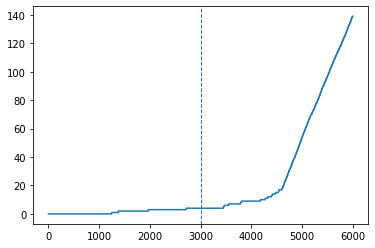

In [3]:
cumulative_reward = run_q_learning(Environment(), NUM_TIME_STEPS, NUM_TIME_STEPS_BEFORE_SECOND_WALL, EPS, LEARNING_RATE, GAMMA)
plt.plot(np.arange(len(cumulative_reward)), cumulative_reward)
plt.axvline(x=NUM_TIME_STEPS_BEFORE_SECOND_WALL, linestyle="dashed", linewidth=1)
plt.xlabel("Time steps")
plt.ylabel("Cumulative reward")

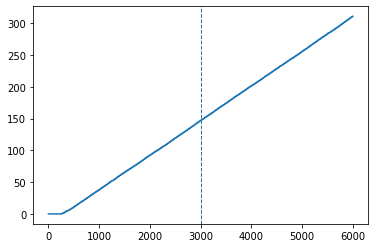

In [4]:
cumulative_reward = run_dyna_q(Environment(), NUM_TIME_STEPS, NUM_TIME_STEPS_BEFORE_SECOND_WALL, EPS, LEARNING_RATE, GAMMA, N)
plt.plot(np.arange(len(cumulative_reward)), cumulative_reward)
plt.axvline(x=NUM_TIME_STEPS_BEFORE_SECOND_WALL, linestyle="dashed", linewidth=1)
plt.xlabel("Time steps")
plt.ylabel("Cumulative reward")

In [5]:
def run_dyna_q_plus(env, num_time_steps, num_time_steps_before_second_wall, eps, learning_rate, gamma, n):
    cumulative_reward = np.zeros(num_time_steps)
    Q = np.zeros((env.grid_size[0], env.grid_size[1], len(env.available_actions)))
    model = {}
    state = env.start_state
    for t in range(num_time_steps):
        # Experience with the environment
        first_wall_active = True if t < num_time_steps_before_second_wall else False
        action = eps_greedy_action_selection(Q, state, eps)
        reward, new_state = env.take_action(state, action, first_wall_active)
        Q[state][action] += learning_rate * (reward + gamma * np.max(Q[new_state]) - Q[state][action])
        model[(state, action)] = (reward, new_state)
        cumulative_reward = update_cumulative_reward(cumulative_reward, reward, t)
        state = new_state

        # Planning
        for _ in range(n):
            rand_state, rand_action = random.choice(list(model.keys()))
            reward, new_state = model[(rand_state, rand_action)]
            Q[rand_state][rand_action] += learning_rate * (reward + gamma * np.max(Q[new_state]) - Q[rand_state][rand_action])

    return cumulative_reward